The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha0


# Gated Recurrent Units (GRU)
:label:`sec_gru`

In :numref:`sec_bptt`,
we discussed how gradients are calculated
in RNNs.
In particular we found that long products of matrices can lead
to vanishing or exploding gradients.
Let's briefly think about what such
gradient anomalies mean in practice:

* We might encounter a situation where an early observation is highly
  significant for predicting all future observations. Consider the somewhat
  contrived case where the first observation contains a checksum and the goal is
  to discern whether the checksum is correct at the end of the sequence. In this
  case, the influence of the first token is vital. We would like to have some
  mechanisms for storing vital early information in a *memory cell*. Without such
  a mechanism, we will have to assign a very large gradient to this observation,
  since it affects all the subsequent observations.
* We might encounter situations where some tokens carry no pertinent
  observation. For instance, when parsing a web page there might be auxiliary
  HTML code that is irrelevant for the purpose of assessing the sentiment
  conveyed on the page. We would like to have some mechanism for *skipping* such
  tokens in the latent state representation.
* We might encounter situations where there is a logical break between parts of
  a sequence. For instance, there might be a transition between chapters in a
  book, or a transition between a bear and a bull market for securities. In
  this case it would be nice to have a means of *resetting* our internal state
  representation.

A number of methods have been proposed to address this. One of the earliest is long short-term memory :cite:`Hochreiter.Schmidhuber.1997` which we
will discuss in :numref:`sec_lstm`. The gated recurrent unit (GRU)
:cite:`Cho.Van-Merrienboer.Bahdanau.ea.2014` is a slightly more streamlined
variant that often offers comparable performance and is significantly faster to
compute  :cite:`Chung.Gulcehre.Cho.ea.2014`.
Due to its simplicity, let's start with the GRU.

## Gated Hidden State

The key distinction between vanilla RNNs and GRUs
is that the latter support gating of the hidden state.
This means that we have dedicated mechanisms for
when a hidden state should be *updated* and
also when it should be *reset*.
These mechanisms are learned and they address the concerns listed above.
For instance, if the first token is of great importance
we will learn not to update the hidden state after the first observation.
Likewise, we will learn to skip irrelevant temporary observations.
Last, we will learn to reset the latent state whenever needed.
We discuss this in detail below.


### Reset Gate and Update Gate

The first thing we need to introduce are
the *reset gate* and the *update gate*.
We engineer them to be vectors with entries in $(0, 1)$
such that we can perform convex combinations.
For instance,
a reset gate would allow us to control how much of the previous state we might still want to remember.
Likewise, an update gate would allow us to control how much of the new state is just a copy of the old state.

We begin by engineering these gates.
:numref:`fig_gru_1` illustrates the inputs for both
the reset and update gates in a GRU, given the input
of the current time step
and the hidden state of the previous time step.
The outputs of two gates
are given by two fully connected layers
with a sigmoid activation function.

![Computing the reset gate and the update gate in a GRU model.](../img/gru-1.svg)
:label:`fig_gru_1`

Mathematically,
for a given time step $t$,
suppose that the input is
a minibatch
$\mathbf{X}_t \in \mathbb{R}^{n \times d}$ (number of examples: $n$, number of inputs: $d$) and the hidden state of the previous time step is $\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$ (number of hidden units: $h$). Then, the reset gate $\mathbf{R}_t \in \mathbb{R}^{n \times h}$ and update gate $\mathbf{Z}_t \in \mathbb{R}^{n \times h}$ are computed as follows:

$$
\begin{aligned}
\mathbf{R}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xr} + \mathbf{H}_{t-1} \mathbf{W}_{hr} + \mathbf{b}_r),\\
\mathbf{Z}_t = \sigma(\mathbf{X}_t \mathbf{W}_{xz} + \mathbf{H}_{t-1} \mathbf{W}_{hz} + \mathbf{b}_z),
\end{aligned}
$$

where $\mathbf{W}_{xr}, \mathbf{W}_{xz} \in \mathbb{R}^{d \times h}$ and
$\mathbf{W}_{hr}, \mathbf{W}_{hz} \in \mathbb{R}^{h \times h}$ are weight
parameters and $\mathbf{b}_r, \mathbf{b}_z \in \mathbb{R}^{1 \times h}$ are
biases.
Note that broadcasting (see :numref:`subsec_broadcasting`) is triggered during the summation.
We use sigmoid functions (as introduced in :numref:`sec_mlp`) to transform input values to the interval $(0, 1)$.

### Candidate Hidden State

Next, let's
integrate the reset gate $\mathbf{R}_t$ with
the regular latent state updating mechanism
in :eqref:`rnn_h_with_state`.
It leads to the following
*candidate hidden state*
$\tilde{\mathbf{H}}_t \in \mathbb{R}^{n \times h}$ at time step $t$:

$$\tilde{\mathbf{H}}_t = \tanh(\mathbf{X}_t \mathbf{W}_{xh} + \left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{hh} + \mathbf{b}_h),$$
:eqlabel:`gru_tilde_H`

where $\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$ and $\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$
are weight parameters,
$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$
is the bias,
and the symbol $\odot$ is the Hadamard (elementwise) product operator.
Here we use a nonlinearity in the form of tanh to ensure that the values in the candidate hidden state remain in the interval $(-1, 1)$.

The result is a *candidate* since we still need to incorporate the action of the update gate.
Comparing with :eqref:`rnn_h_with_state`,
now the influence of the previous states
can be reduced with the
elementwise multiplication of
$\mathbf{R}_t$ and $\mathbf{H}_{t-1}$
in :eqref:`gru_tilde_H`.
Whenever the entries in the reset gate $\mathbf{R}_t$ are close to 1, we recover a vanilla RNN such as in :eqref:`rnn_h_with_state`.
For all entries of the reset gate $\mathbf{R}_t$ that are close to 0, the candidate hidden state is the result of an MLP with $\mathbf{X}_t$ as input. Any pre-existing hidden state is thus *reset* to defaults.

:numref:`fig_gru_2` illustrates the computational flow after applying the reset gate.

![Computing the candidate hidden state in a GRU model.](../img/gru-2.svg)
:label:`fig_gru_2`


### Hidden State

Finally, we need to incorporate the effect of the update gate $\mathbf{Z}_t$. This determines the extent to which the new hidden state $\mathbf{H}_t \in \mathbb{R}^{n \times h}$ is just the old state $\mathbf{H}_{t-1}$ and by how much the new candidate state $\tilde{\mathbf{H}}_t$ is used.
The update gate $\mathbf{Z}_t$ can be used for this purpose, simply by taking elementwise convex combinations between both $\mathbf{H}_{t-1}$ and $\tilde{\mathbf{H}}_t$.
This leads to the final update equation for the GRU:

$$\mathbf{H}_t = \mathbf{Z}_t \odot \mathbf{H}_{t-1}  + (1 - \mathbf{Z}_t) \odot \tilde{\mathbf{H}}_t.$$


Whenever the update gate $\mathbf{Z}_t$ is close to 1, we simply retain the old state. In this case the information from $\mathbf{X}_t$ is essentially ignored, effectively skipping time step $t$ in the dependency chain. In contrast, whenever $\mathbf{Z}_t$ is close to 0, the new latent state $\mathbf{H}_t$ approaches the candidate latent state $\tilde{\mathbf{H}}_t$. These designs can help us cope with the vanishing gradient problem in RNNs and better capture dependencies for sequences with large time step distances.
For instance,
if the update gate has been close to 1
for all the time steps of an entire subsequence,
the old hidden state at the time step of its beginning
will be easily retained and passed
to its end,
regardless of the length of the subsequence.



:numref:`fig_gru_3` illustrates the computational flow after the update gate is in action.

![Computing the hidden state in a GRU model.](../img/gru-3.svg)
:label:`fig_gru_3`


In summary, GRUs have the following two distinguishing features:

* Reset gates help capture short-term dependencies in sequences.
* Update gates help capture long-term dependencies in sequences.

## Implementation from Scratch

To gain a better understanding of the GRU model, let's implement it from scratch.


In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

### (**Initializing Model Parameters**)

The first step is to initialize the model parameters.
We draw the weights from a Gaussian distribution
with standard deviation to be `sigma` and set the bias to 0. The hyperparameter `num_hiddens` defines the number of hidden units.
We instantiate all weights and biases relating to the update gate, the reset gate, and the candidate hidden state.


In [2]:
class GRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: tf.Variable(tf.random.normal(shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          tf.Variable(tf.zeros(num_hiddens)))

        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state

### Defining the Model

Now we are ready to [**define the GRU forward computation**].
Its structure is the same as that of the basic RNN cell, except that the update equations are more complex.


In [3]:
@d2l.add_to_class(GRUScratch)
def forward(self, inputs, H=None):
    matmul_H = lambda A, B: tf.matmul(A, B) if H is not None else 0
    outputs = []
    for X in inputs:
        Z = tf.sigmoid(tf.matmul(X, self.W_xz) + (
            tf.matmul(H, self.W_hz) if H is not None else 0) + self.b_z)
        if H is None: H = tf.zeros_like(Z)
        R = tf.sigmoid(tf.matmul(X, self.W_xr) +
                        tf.matmul(H, self.W_hr) + self.b_r)
        H_tilda = tf.tanh(tf.matmul(X, self.W_xh) +
                           tf.matmul(R * H, self.W_hh) + self.b_h)
        H = Z * H + (1 - Z) * H_tilda
        outputs.append(H)
    return outputs, (H, )

### Training

[**Training**] a language model on *The Time Machine* dataset
works in exactly the same manner as in :numref:`sec_rnn-scratch`.


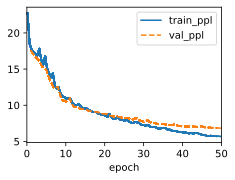

In [4]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
with d2l.try_gpu():
    gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
    model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1)
trainer.fit(model, data)

## [**Concise Implementation**]

In high-level APIs,
we can directly
instantiate a GPU model.
This encapsulates all the configuration detail that we made explicit above.


In [5]:
class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = tf.keras.layers.GRU(num_hiddens, return_sequences=True,
                                       return_state=True)

The code is significantly faster in training as it uses compiled operators rather than Python for many details that we spelled out before.


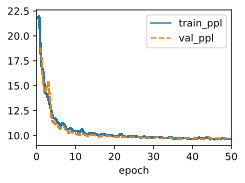

In [6]:
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
with d2l.try_gpu():
    model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

After training,
we print out the perplexity on the training set
and the predicted sequence following
the provided prefix.


In [7]:
model.predict('it has', 20, data.vocab)

'it has the the the the the'

## Summary

* Gated RNNs can better capture dependencies for sequences with large time step distances.
* Reset gates help capture short-term dependencies in sequences.
* Update gates help capture long-term dependencies in sequences.
* GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can also skip subsequences by turning on the update gate.


## Exercises

1. Assume that we only want to use the input at time step $t'$ to predict the output at time step $t > t'$. What are the best values for the reset and update gates for each time step?
1. Adjust the hyperparameters and analyze the their influence on running time, perplexity, and the output sequence.
1. Compare runtime, perplexity, and the output strings for `rnn.RNN` and `rnn.GRU` implementations with each other.
1. What happens if you implement only parts of a GRU, e.g., with only a reset gate or only an update gate?


[Discussions](https://discuss.d2l.ai/t/3860)
